Philippe Joly 2025-08-14

# Test Data Overview

looks at the structure/patterns of generated test data

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import sys
import os
import pandas as pd
sys.path.append(os.path.expanduser('~/albatros_analysis/src/correlations'))

## PFB Pipeline Test

In [133]:
fns = [
    "/scratch/philj0ly/test_08_21/test_constant_2100_64.npz", # generated constant time stream 
    "/scratch/philj0ly/test_08_21/test_uniform_2100_64.npz", # generated random (uniform distribution) time stream
    "/scratch/philj0ly/test_08_21/test_gaussian_2100_64.npz", # generated gaussian time stream
    "/scratch/philj0ly/test_08_21/test_sine_2100_64.npz", # Generated Sinusoidal 5 kHz time Stream
]
pu = ['constant time stream','uniform distribution', 'Gaussian distribution', 'Sine time stream']

spectra = []
avg_spectra = []

df_record = 125e6/2048 # (Hz) frequency range / # of channels
df = df_record / 64 # <- OSAMP

for i, fn in enumerate(fns):
    with np.load(fn) as f:
        spectra.append(np.ma.MaskedArray(data=f['data'], mask=f['mask']))
        avg_spectra.append(np.mean(np.abs(spectra[i]), axis=3))
        print(pu[i], 'spectrum shape:', spectra[i].shape)

constant time stream spectrum shape: (2, 2, 64, 49)
uniform distribution spectrum shape: (2, 2, 64, 49)
Gaussian distribution spectrum shape: (2, 2, 64, 49)
Sine time stream spectrum shape: (2, 2, 64, 49)


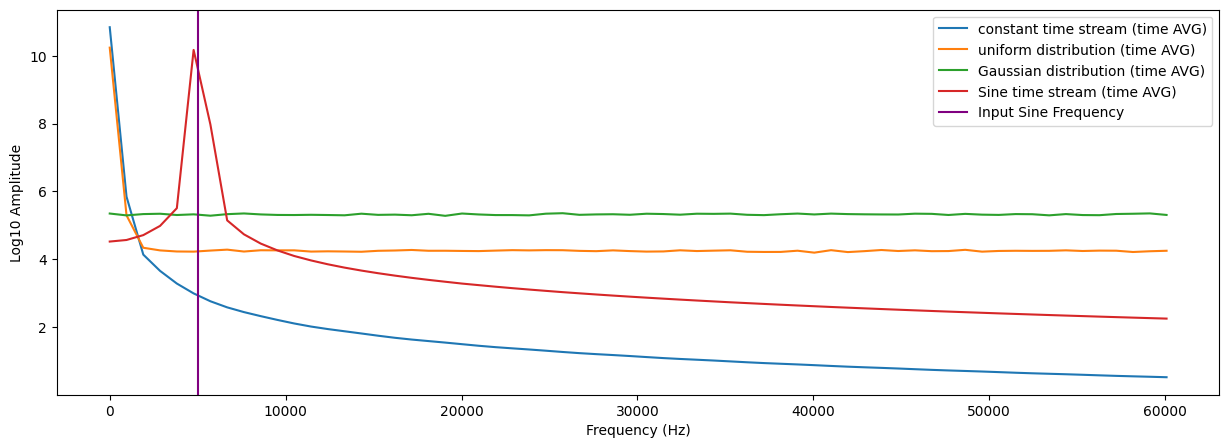

In [134]:
t = 6
single_t = False

log = True
avg = True

df = 125e6/2048/64
freqs = np.arange(spectra[0].shape[2])*df

plt.figure(figsize=(15,5))

for i in range(len(fns)):    
    if log:
        if single_t:
            plt.plot(freqs, np.log10(np.abs(spectra[i][0,0,:,t])), label=pu[i])
        if avg:
            plt.plot(freqs, np.log10(avg_spectra[i][0,0]), label=f"{pu[i]} (time AVG)")
    else:
        if single_t:
            plt.plot(freqs, np.abs(spectra[i][0,0,:,t]), label=pu[i])
        if avg:
            plt.plot(freqs, avg_spectra[i][0,0], label=f"{pu[i]} AVG")

plt.axvline(5e3, color='purple', label="Input Sine Frequency")

plt.xlabel('Frequency (Hz)')  
if log:
    plt.ylabel('Log10 Amplitude')
else:
    plt.ylabel('amplitude')
    
plt.legend()

plt.show()

| Input Time Stream | Expected Output | Actual Output | Test Passed |
| :---------------- | :-------------: | :-----------: | :---------: |
| Constant              |  Delta at 0 Hz  | Delta at 0 Hz | Yes |
| Uniform | White Noise | White Noise (Spike at 0) | Yes |
| Gaussian | White Noise | White Noise | Yes |
| Sinusoidal | Delta at Frequency | Delta at Frequency | Yes |

## File to Time Stream Test

In [32]:
from baseband_data_classes import get_header, BasebandFloat

In [44]:
path_dir = '/scratch/philj0ly/test_baseband_data2'
path_dir = '/scratch/philj0ly/simple_test_data'
fn = '17214/1721400005.raw'
f_path = os.path.join(path_dir, fn)

header = get_header(f_path, verbose=True)

Not reading any data
Header Bytes = 2008. Bytes per packet = 1204. Channel length = 120. Spectra per packet: 5. Bit mode: 4. Total packets = 415282. Read packets = 0. Have trimble = 1. Channels: [ 64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81
  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99
 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135
 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153
 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171
 172 173 174 175 176 177 178 179 180 181 182 183] GPS week = 0. GPS timestamp = 1721400005. GPS latitude = 79.41560919999999. GPS longitude = -90.7723716. GPS elevation = 179.077.


In [45]:
# max is 83056
bb = BasebandFloat(f_path, readlen=1000)
print('Data shapes:', bb.pol0.shape, bb.pol1.shape)

Reading 1000 packets
took 0.000 seconds to read raw data on  /scratch/philj0ly/simple_test_data/17214//1721400005.raw
Data shapes: (5000, 120) (5000, 120)


In [46]:
f_bin = 125*1e6 / 2048
npol = 2

chnls = header['channels'].shape[0]
packs = bb.pol0.shape[0]

spectrum = np.zeros((npol, packs, chnls), dtype='complex64')
freqs = []
for i in range(chnls):
    freqs.append(header['channels'][i]*f_bin)
    
    for j in range(packs):
        spectrum[0, j, i] = np.abs(bb.pol0[j,i])
        spectrum[0, j, i] = np.abs(bb.pol1[j,i])

    if i % 10 == 0:
        print(f"{i}/{chnls} Channels Processed")
        
freqs = np.array(freqs)   

0/120 Channels Processed
10/120 Channels Processed
20/120 Channels Processed
30/120 Channels Processed
40/120 Channels Processed
50/120 Channels Processed
60/120 Channels Processed
70/120 Channels Processed
80/120 Channels Processed
90/120 Channels Processed
100/120 Channels Processed
110/120 Channels Processed


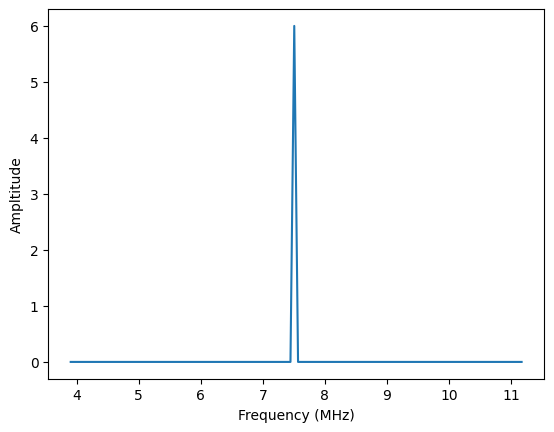

In [48]:
plt.plot(freqs*1e-6, spectrum[0,300])
plt.xlabel("Frequency (MHz)")
plt.ylabel("Ampltitude")
plt.show()